In [ ]:
"""
 - get probability matrix
 - calculate randomwalk and wasserstein
 - plot results along with jaccard-shortest
"""

In [108]:
from scipy.io import loadmat
from scipy.sparse import find
from scipy.sparse.csgraph import dijkstra
from scipy.linalg import sqrtm
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
from scipy.stats import wasserstein_distance
import numpy as np
import numpy.linalg as lalg
import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
def karate_labels():
    ticks, labels = plt.xticks()
    mr_hi = set([1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 17, 18, 20, 22])
    labels = [int(x.get_text())+1 for x in labels]
    for i in range(len(labels)):
        if labels[i] in mr_hi:
            labels[i] = "#_{}".format(labels[i])
    plt.xticks(ticks, labels)

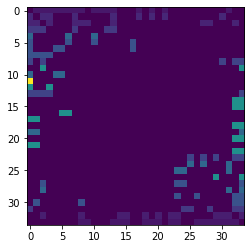

In [51]:
mat = loadmat('karate.mat')
S = mat['Problem'][0][0][2]
I,J,V = find(S)
n = max(max(I), max(J)) + 1
A = np.zeros((n,n))
for i,j,v in zip(I,J,V):
    A[i,j] = v
D = np.identity(n, dtype=A.dtype) * np.sum(A, axis=1)

P = lalg.inv(D) @ A
plt.imshow(P)

In [111]:
steps = 4
Ppow = lalg.matrix_power(P, steps)

In [112]:
# cluster walktrap distance
Dsqrt = lalg.inv(sqrtm(D))
hde = Dsqrt @ Ppow
Z = linkage(hde, method='ward', metric='euclidean')

In [109]:
jacc = pdist(A, metric='jaccard')
bacon = dijkstra(A, directed=False, unweighted=True)
dist = jacc * squareform(bacon)
Z = linkage(dist, method='ward')

In [105]:
# wasserstein distance
dist = pdist(Ppow, wasserstein_distance)
Z = linkage(dist, method='ward')

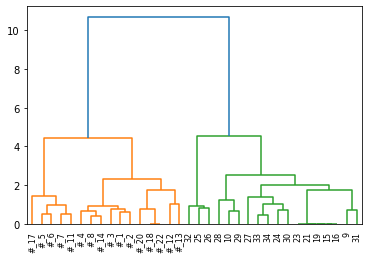

In [110]:
dend = dendrogram(Z, leaf_rotation=90, leaf_font_size=8)
karate_labels()

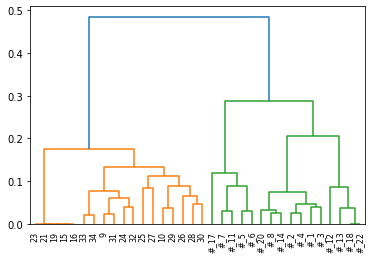

In [113]:
dend = dendrogram(Z, leaf_rotation=90, leaf_font_size=8)
karate_labels()